In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [6]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ASD','AUD','BIL. CHIR','BIP','CUD','EPILEPSY','FATIGUE','GOUT','HOARDING','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PTSD','RH. ARTHRITIS','SJOGRENS','SZC','THYROID DIS.','TOURETTES']

In [7]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [8]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [9]:
df_list[0]

,p1,p2,rg,se,z,p
0,munged/ADHD.sumstats.gz,munged/ANOREXIA.sumstats.gz,-0.0931,0.0370,-2.5141,1.193500e-02
1,munged/ADHD.sumstats.gz,munged/ANXIETY.sumstats.gz,0.3234,0.1350,2.3950,1.661900e-02
2,munged/ADHD.sumstats.gz,munged/ASD.sumstats.gz,0.4326,0.0513,8.4319,3.402200e-17
3,munged/ADHD.sumstats.gz,munged/AUD.sumstats.gz,-0.0135,0.0261,-0.5154,6.062400e-01
4,munged/ADHD.sumstats.gz,munged/BIL_CHIR.sumstats.gz,0.0809,0.0416,1.9447,5.181000e-02
5,munged/ADHD.sumstats.gz,munged/BIP.sumstats.gz,0.2366,0.0331,7.1576,8.210900e-13
6,munged/ADHD.sumstats.gz,munged/CUD.sumstats.gz,0.6633,0.0428,15.4853,4.359100e-54
7,munged/ADHD.sumstats.gz,munged/EPILEPSY.sumstats.gz,0.1418,0.0539,2.6332,8.458800e-03
8,munged/ADHD.sumstats.gz,munged/FATIGUE.sumstats.gz,0.0760,0.0718,1.0575,2.902800e-01
9,munged/ADHD.sumstats.gz,munged/GOUT.sumstats.gz,0.0647,0.0371,1.7435,8.125000e-02


In [10]:
#function to fill a dataframe with values from the ldsc analysis

def make_correlation_matrix(column, df_list):
    array = np.zeros((len(disorders), len(disorders)))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            for j in range(i + 1, len(val) + 1 + i):  # exclude the diagonal
                array[j, i] = val[j - i - 1]
                

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else: np.fill_diagonal(array,0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array

In [11]:
corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix('rg', df_list)

In [12]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)

In [13]:
full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True)

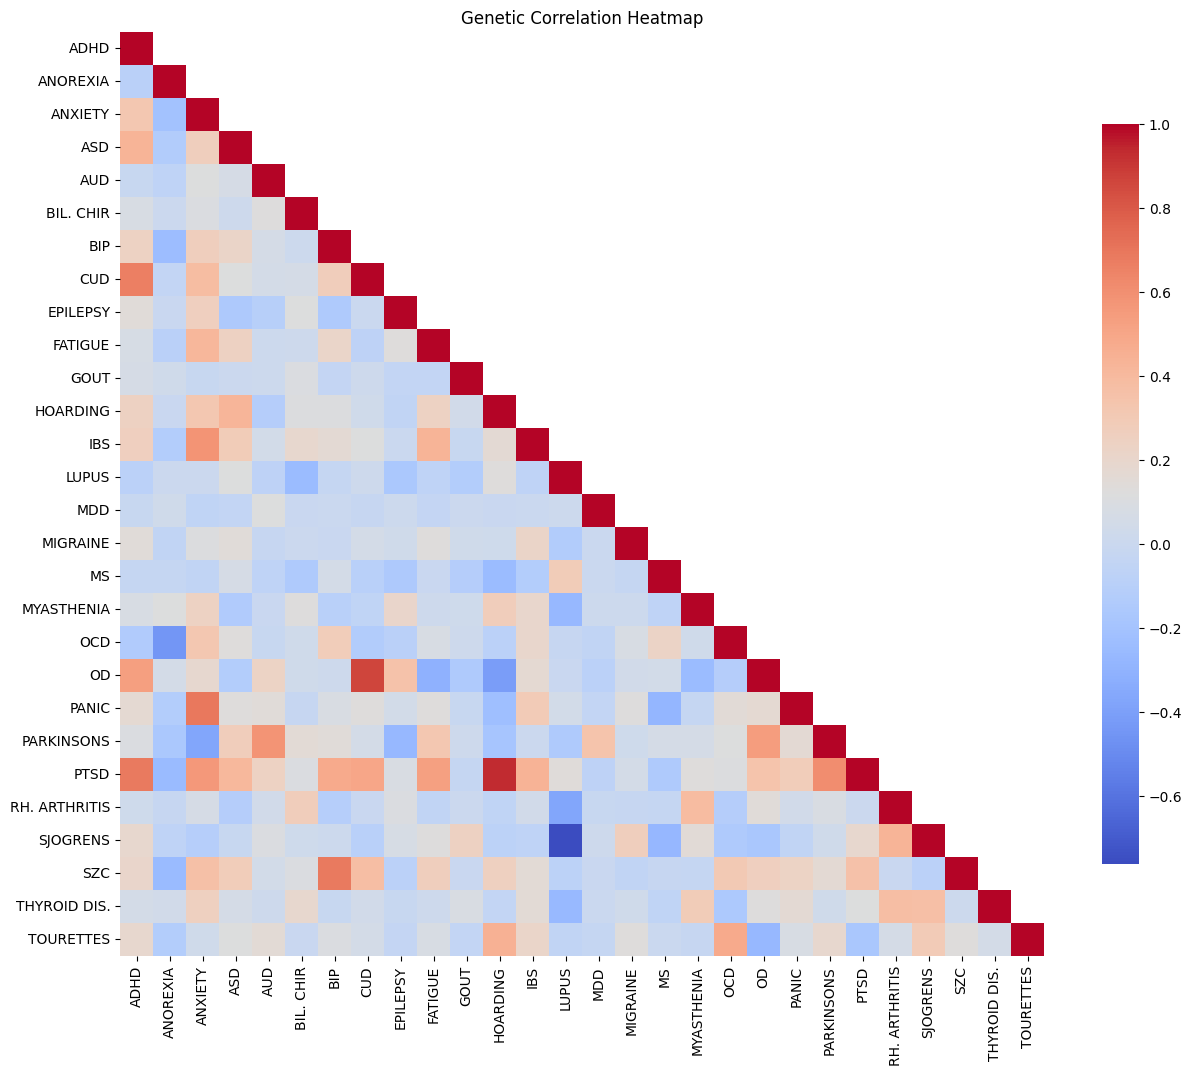

In [14]:
# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
sns.heatmap(gen_corr_df, cmap='coolwarm', mask=mask, square=True, cbar_kws={"shrink": 0.8})
plt.title('Genetic Correlation Heatmap')
plt.show()

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

gen_corr_df.dropna(inplace=True)
scaled_df = StandardScaler().fit_transform(gen_corr_df)

In [32]:
print(scaled_df[:5])

[[ 3.13077505  0.17673553 -0.77697955 -0.55553497 -0.42108531 -0.38732234
  -0.46485521 -0.37550989 -0.18611397 -0.42968151 -0.17898352 -0.2265642
  -0.47921815  0.08248319 -0.192744   -0.31325827 -0.07632906 -0.29301311
  -0.26445811 -0.33015129 -0.3488984  -0.35304303 -0.26663949 -0.31952608
  -0.27991842 -0.21975532 -0.20308475 -0.19245009]
 [-1.13403385  4.47276359 -0.77697955 -0.55553497 -0.42108531 -0.38732234
  -0.46485521 -0.37550989 -0.18611397 -0.42968151 -0.17898352 -0.2265642
  -0.47921815  0.08248319 -0.192744   -0.31325827 -0.07632906 -0.29301311
  -0.26445811 -0.33015129 -0.3488984  -0.35304303 -0.26663949 -0.31952608
  -0.27991842 -0.21975532 -0.20308475 -0.19245009]
 [ 0.4909711  -0.72199355  2.87718388 -0.55553497 -0.42108531 -0.38732234
  -0.46485521 -0.37550989 -0.18611397 -0.42968151 -0.17898352 -0.2265642
  -0.47921815  0.08248319 -0.192744   -0.31325827 -0.07632906 -0.29301311
  -0.26445811 -0.33015129 -0.3488984  -0.35304303 -0.26663949 -0.31952608
  -0.27991842

c:\Users\annei\anaconda3\envs\psych_overlap\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\annei\anaconda3\envs\psych_overlap\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\annei\anaconda3\envs\psych_overlap\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\annei\anaconda3\envs\psych_overlap\lib\site-packages\sklearn\cluster\_

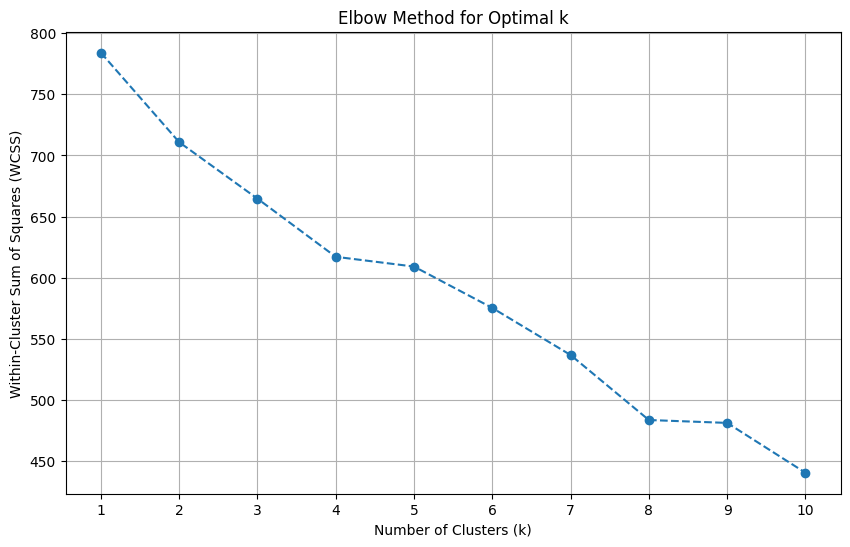

In [33]:


# Perform k-means clustering with different values of k
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

c:\Users\annei\anaconda3\envs\psych_overlap\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


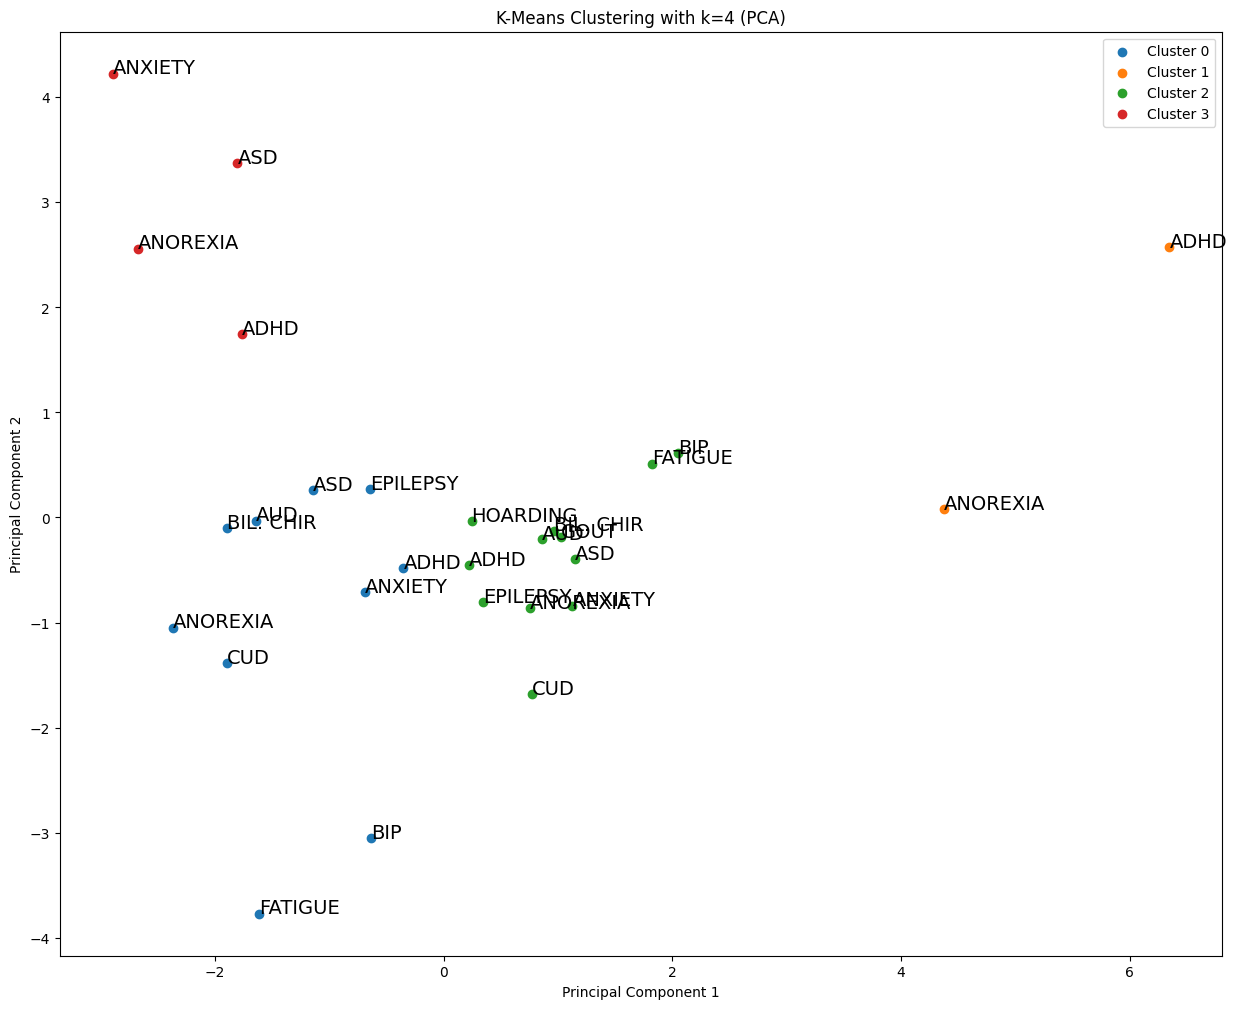

In [43]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2) 
pca_result = pca.fit_transform(scaled_df)

# Perform k-means clustering with k=4 on the reduced data
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_result)

# Add cluster labels to the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plot clusters using a scatter plot
plt.figure(figsize=(15,12))
for cluster in range(4):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}')
    for disorder_name, x, y in zip(gen_corr_df.index, cluster_data['PC1'], cluster_data['PC2']):
        plt.annotate(disorder_name, (x, y), fontsize=14)
plt.title('K-Means Clustering with k=4 (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [41]:
cluster_labels = pca_df['Cluster']
disorder_names = gen_corr_df.index

# Print disorders in each cluster
for cluster in range(4):
    cluster_disorders = disorder_names[cluster_labels == cluster]
    print(f"Cluster {cluster} disorders:")
    for disorder in cluster_disorders:
        print(disorder)
    print()

Cluster 0 disorders:
ADHD
ANOREXIA
AUD
BIL. CHIR
EPILEPSY
GOUT
LUPUS
MDD
MIGRAINE
MS

Cluster 1 disorders:
PTSD
SZC

Cluster 2 disorders:
ANXIETY
ASD
BIP
CUD
FATIGUE
HOARDING
IBS
OCD
OD
PANIC
PARKINSONS
TOURETTES

Cluster 3 disorders:
MYASTHENIA
RH. ARTHRITIS
SJOGRENS
THYROID DIS.

